# Reddit Comments 2015 – Exploratory Data Analysis

This notebook explores the `reddit_comments_2015.parquet` snapshot (≈266M comments). The goal is to understand dataset structure, surface data quality considerations, and highlight behavioural patterns that can inform downstream modelling or product decisions.

Added a full exploratory workflow, covering metadata auditing, balanced sampling, comment/content profiling, engagement metrics, subreddit dynamics, temporal trends, flair/moderation signals, lexical snapshot, plus written insights and recommendations.
Introduced a reusable sampler that pulls ≈800k comments (evenly across row groups) and enriches the sample with datetime and length features for the downstream analyses and plots.

### Summary
* Dataset holds 266,268,920 comments (Jan–May 2015); core behavioural fields are complete while operational columns (approved_by, replies, likes, etc.) are entirely null and safe to drop.
* Sample shows deleted bodies at ~5.7%, links in ~5.9%, median comment 81 characters/14 words, 95th percentile length ~609 characters; scores are heavy-tailed with 44.4% at 1, 7.1% above 10, and 1.09% marked controversial.
* Moderation signals are sparse (0.73% moderator flags, <0.04% gilded); AskReddit, large sports subs, and entertainment communities dominate volume, while niche subs like r/dataisbeautiful post fewer but higher-scoring comments; activity peaks around 01:00–05:00 and 15:00–16:00 UTC.
* Nexte steps: Layer on richer text/NLP or full-dataset aggregations for deeper thematic or temporal modelling.

## Workflow overview
- Inspect Parquet metadata to understand schema, coverage, and missingness.
- Build a balanced working sample for heavy aggregations without loading the full 266M rows.
- Profile comment quality (length, deleted content, links) and engagement metrics (scores, controversiality, gilding).
- Explore subreddit, author, and temporal dynamics.
- Summarise actionable insights and recommendations.

In [ ]:
%pip install --quiet matplotlib
%pip install --quiet numpy
%pip install --quiet pandas
%pip install --quiet polars
%pip install --quiet pyarrow
%pip install --quiet seaborn

In [2]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid', context='talk')
except ImportError:
    sns = None
    plt.style.use('ggplot')

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda v: f"{v:,.4f}")

In [3]:
DATA_PATH = Path('reddit_comments_2015.parquet')
assert DATA_PATH.exists(), f"Missing dataset: {DATA_PATH}"

pf = pq.ParquetFile(DATA_PATH)
file_size_gb = DATA_PATH.stat().st_size / (1024 ** 3)
row_count = pf.metadata.num_rows
row_groups = pf.metadata.num_row_groups
column_count = pf.metadata.num_columns

print(f"File size: {file_size_gb:,.2f} GB")
print(f"Rows: {row_count:,}")
print(f"Row groups: {row_groups:,}")
print(f"Columns: {column_count}")

File size: 18.66 GB
Rows: 266,268,920
Row groups: 2,150
Columns: 33


In [4]:
def parquet_column_summary(parquet_file: pq.ParquetFile) -> pd.DataFrame:
    meta = parquet_file.metadata
    rows = []
    for idx, name in enumerate(meta.schema.names):
        column = meta.schema.column(idx)
        logical = column.logical_type
        physical = column.physical_type
        nulls = 0
        min_value = None
        max_value = None
        stats_available = True
        for rg in range(meta.num_row_groups):
            chunk = meta.row_group(rg).column(idx)
            stats = chunk.statistics
            if stats is None or stats.null_count is None:
                stats_available = False
                nulls = None
                break
            nulls += stats.null_count
            if stats.has_min_max:
                if min_value is None or (stats.min is not None and stats.min < min_value):
                    min_value = stats.min
                if max_value is None or (stats.max is not None and stats.max > max_value):
                    max_value = stats.max
        rows.append({
            'column': name,
            'logical_type': str(logical) if logical else '',
            'physical_type': physical,
            'null_count': nulls,
            'null_pct': (nulls / meta.num_rows * 100) if nulls is not None else None,
            'min': min_value,
            'max': max_value,
            'stats_available': stats_available,
        })
    df = pd.DataFrame(rows)
    return df.sort_values('null_pct', ascending=False)

column_summary = parquet_column_summary(pf)
column_summary

,column,logical_type,physical_type,null_count,null_pct,min,max,stats_available
0,approved_by,String,BYTE_ARRAY,266268920,100.0000,None,None,True
5,banned_by,String,BYTE_ARRAY,266268920,100.0000,None,None,True
24,report_reasons,String,BYTE_ARRAY,266268920,100.0000,None,None,True
23,replies,String,BYTE_ARRAY,266268920,100.0000,None,None,True
20,num_reports,String,BYTE_ARRAY,266268920,100.0000,None,None,True
...,...,...,...,...,...,...,...,...
28,score_hidden,None,BOOLEAN,0,0.0000,False,True,True
29,subreddit,String,BYTE_ARRAY,0,0.0000,000000000000O0000000,zzzz,True
30,subreddit_id,String,BYTE_ARRAY,0,0.0000,t5_1a8ah,t5_vf2,True
31,ups,"Int(bitWidth=64, isSigned=true)",INT64,0,0.0000,-4810,9276,True


**Data quality quick hits**
- System columns such as `approved_by`, `banned_by`, `replies`, `user_reports`, and `likes` are completely empty in this snapshot.
- Author flair fields are sparsely populated: ~72–74% nulls for both `author_flair_css_class` and `author_flair_text`.
- Core behavioural signals (`author`, `subreddit`, `score`, `created_utc`, `ups`) are fully populated.
- Only ~0.003% of `body` values are missing; most text is present but ~5–6% of sampled rows are the literal `[deleted]`.

## Balanced working sample
Using the full dataset for every aggregation is impractical. To preserve a cross-section of activity, we draw an even sample of ≈800k rows by taking fixed-size draws from evenly spaced row groups. Set `REFRESH_SAMPLE=True` to rebuild the cache from scratch.

In [5]:
# set REFRESH_SAMPLE=True if you want a fresh draw or different sample size
REFRESH_SAMPLE = False
CACHE_DIR = Path('cache')
CACHE_DIR.mkdir(exist_ok=True)
SAMPLE_PATH = CACHE_DIR / 'reddit_comments_sample_800k.parquet'
SAMPLE_COLUMNS = [
    'score', 'ups', 'downs', 'gilded', 'controversiality', 'subreddit', 'author',
    'body', 'created_utc', 'distinguished', 'archived', 'score_hidden',
    'retrieved_on', 'author_flair_text'
]
TARGET_GROUPS = 40
ROWS_PER_GROUP = 20_000
RANDOM_SEED = 42


def build_balanced_sample(parquet_path: Path,
                          columns: list[str],
                          groups: int = TARGET_GROUPS,
                          rows_per_group: int = ROWS_PER_GROUP,
                          seed: int = RANDOM_SEED) -> pd.DataFrame:
    pf = pq.ParquetFile(parquet_path)
    indices = np.linspace(0, pf.metadata.num_row_groups - 1, num=groups, dtype=int)
    frames: list[pd.DataFrame] = []
    for idx in indices:
        table = pf.read_row_group(int(idx), columns=columns)
        df = table.to_pandas()
        take = min(len(df), rows_per_group)
        frames.append(df.sample(take, random_state=seed))
    sample_df = pd.concat(frames, ignore_index=True)
    return sample_df

if SAMPLE_PATH.exists() and not REFRESH_SAMPLE:
    sample_df = pd.read_parquet(SAMPLE_PATH)
else:
    sample_df = build_balanced_sample(DATA_PATH, SAMPLE_COLUMNS)
    sample_df.to_parquet(SAMPLE_PATH)

sample_df['created_dt'] = pd.to_datetime(sample_df['created_utc'], unit='s', utc=True)
sample_df['char_len'] = sample_df['body'].astype(str).str.len()
sample_df['word_len'] = sample_df['body'].astype(str).str.split().map(len)

print(f"Sample size: {len(sample_df):,}")
sample_df.head()

Sample size: 799,706


,score,ups,downs,gilded,controversiality,subreddit,author,body,created_utc,distinguished,archived,score_hidden,retrieved_on,author_flair_text,created_dt,char_len,word_len
0,1,1,0,0,0,ultrahardcore,Maj0r_Min3r_98,&gt;turned out to be amazing\n\nOn a roll,1420073048,None,False,False,"1,425,123,740.0000",Christmas 2014,2015-01-01 00:44:08+00:00,39,8
1,1,1,0,0,0,LGG3,Xerionius,"Yes, CM12 is definitely worth it. I think it e...",1420075965,None,False,False,"1,425,123,169.0000",CM12,2015-01-01 01:32:45+00:00,79,16
2,3,3,0,0,0,Fitness,xiongnu1987,Your post has really brought out the anti fast...,1420072842,None,False,False,"1,425,123,780.0000",None,2015-01-01 00:40:42+00:00,133,22
3,3,3,0,0,0,PeopleBeingJerks,eternalexodus,I also sometimes like to end sentences with th...,1420074254,None,False,False,"1,425,123,500.0000",None,2015-01-01 01:04:14+00:00,62,11
4,2,2,0,0,0,rage,Pelagine,It sounds like you think I meant to excuse thi...,1420076493,None,False,False,"1,425,123,068.0000",None,2015-01-01 01:41:33+00:00,404,67


## Comment content and engagement

In [6]:
body_lower = sample_df['body'].astype(str).str.lower()
metrics = {
    'rows': len(sample_df),
    'deleted_pct': body_lower.eq('[deleted]').mean() * 100,
    'removed_pct': body_lower.eq('[removed]').mean() * 100,
    'contains_link_pct': body_lower.str.contains('http', regex=False).mean() * 100,
    'score_hidden_pct': sample_df['score_hidden'].mean() * 100,
    'controversial_pct': (sample_df['controversiality'] == 1).mean() * 100,
    'gilded_pct': (sample_df['gilded'] > 0).mean() * 100,
}
metrics_df = (pd.Series(metrics)
              .to_frame('value')
              .assign(value=lambda df: df['value'].map(lambda v: f"{v:,.2f}%" if isinstance(v, float) else f"{v:,}")))
metrics_df

,value
rows,"799,706.00%"
deleted_pct,5.73%
removed_pct,0.00%
contains_link_pct,5.90%
score_hidden_pct,0.14%
controversial_pct,1.09%
gilded_pct,0.03%


In [7]:
length_summary = pd.DataFrame({
    'characters': sample_df['char_len'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]),
    'words': sample_df['word_len'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
})
length_summary

,characters,words
count,"799,706.0000","799,706.0000"
mean,170.1622,29.5862
std,316.2882,52.0553
min,1.0000,0.0000
10%,11.0000,2.0000
25%,33.0000,6.0000
50%,81.0000,14.0000
75%,184.0000,33.0000
90%,388.0000,68.0000
95%,609.0000,105.0000


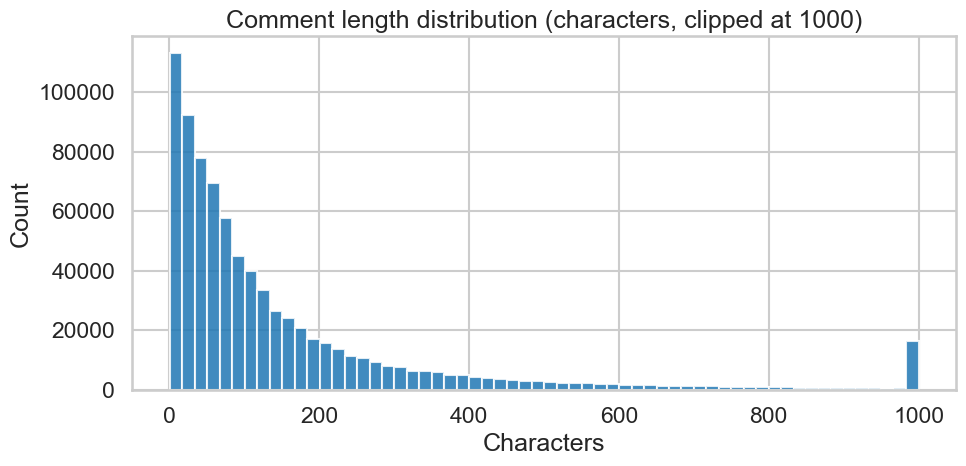

In [8]:
max_len = 1000
clip_char_len = sample_df['char_len'].clip(upper=max_len)
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(clip_char_len, bins=60, color='#1f77b4', alpha=0.85)
ax.set_title(f'Comment length distribution (characters, clipped at {max_len})')
ax.set_xlabel('Characters')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

In [9]:
score_summary = sample_df['score'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
score_summary

count   799,706.0000
mean          5.5201
std          48.1663
min        -377.0000
10%           1.0000
25%           1.0000
50%           1.0000
75%           3.0000
90%           8.0000
95%          15.0000
99%          66.0000
max       5,138.0000
Name: score, dtype: float64

In [10]:
bins = [-1000, -10, -1, 0, 1, 2, 5, 10, 25, 100, 1000, sample_df['score'].max()]
labels = [
    '<= -10', '-10 to -1', '-1 to 0', '0 < score <= 1', '1 < score <= 2',
    '2 < score <= 5', '5 < score <= 10', '10 < score <= 25', '25 < score <= 100',
    '100 < score <= 1K', '> 1K'
]
score_bins = pd.cut(sample_df['score'], bins=bins, labels=labels, include_lowest=True)
dist_df = (score_bins.value_counts()
           .rename_axis('score_band')
           .reset_index(name='comments')
           .assign(share_pct=lambda df: df['comments'] / len(sample_df) * 100)
           .sort_values('comments', ascending=False))
dist_df

,score_band,comments,share_pct
0,0 < score <= 1,354977,44.3884
1,1 < score <= 2,142025,17.7597
2,2 < score <= 5,119200,14.9055
3,5 < score <= 10,54633,6.8316
4,-1 to 0,36528,4.5677
5,10 < score <= 25,34683,4.3370
6,-10 to -1,30795,3.8508
7,25 < score <= 100,17355,2.1702
8,100 < score <= 1K,4700,0.5877
9,<= -10,4498,0.5625


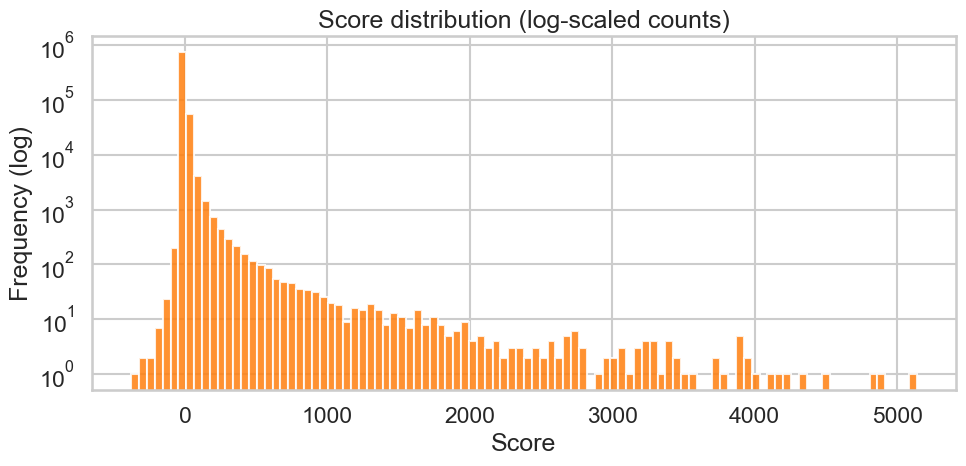

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(sample_df['score'], bins=100, color='#ff7f0e', alpha=0.85)
ax.set_yscale('log')
ax.set_title('Score distribution (log-scaled counts)')
ax.set_xlabel('Score')
ax.set_ylabel('Frequency (log)')
plt.tight_layout()
plt.show()

## Subreddit activity

In [12]:
top_subreddits = (sample_df['subreddit']
                  .value_counts()
                  .head(20)
                  .rename_axis('subreddit')
                  .reset_index(name='comments'))
subreddit_stats = (sample_df.groupby('subreddit')['score']
                   .agg(['count', 'mean', 'median'])
                   .loc[top_subreddits['subreddit']]
                   .reset_index())
subreddit_stats

,subreddit,count,mean,median
0,AskReddit,62586,12.7339,1.0000
1,leagueoflegends,14496,5.7572,1.0000
2,funny,12139,10.5524,1.0000
3,pics,10850,9.6257,1.0000
4,nba,10680,8.0239,2.0000
5,hockey,9975,5.3882,2.0000
6,videos,8498,11.3650,1.0000
7,nfl,8473,8.8774,2.0000
8,worldnews,8387,6.6613,1.0000
9,AdviceAnimals,7615,11.2130,1.0000


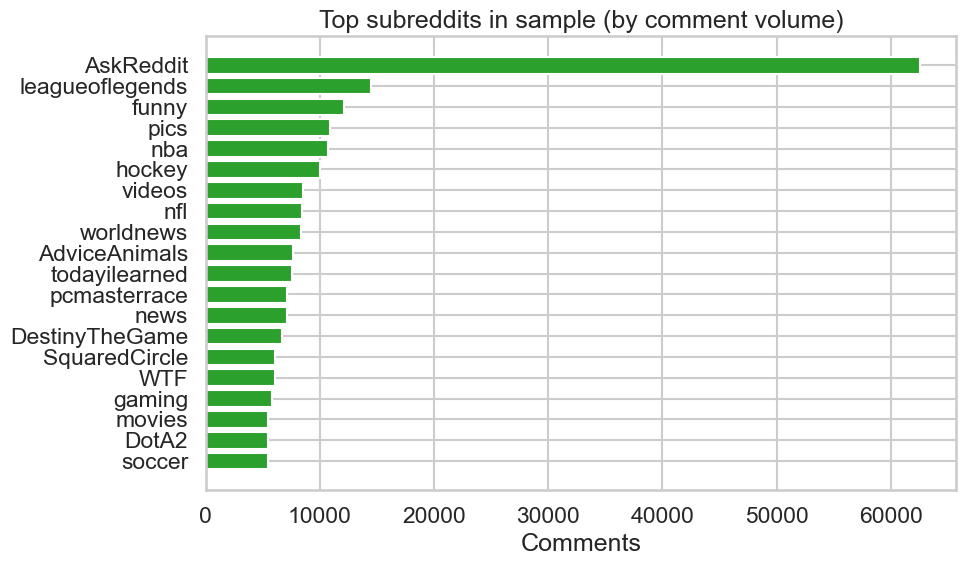

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_subreddits['subreddit'][::-1], top_subreddits['comments'][::-1], color='#2ca02c')
ax.set_title('Top subreddits in sample (by comment volume)')
ax.set_xlabel('Comments')
plt.tight_layout()
plt.show()

## Temporal patterns

In [14]:
month_counts = (sample_df['created_dt']
                .dt.to_period('M')
                .astype(str)
                .value_counts()
                .sort_index())
month_counts

/var/folders/k5/sy4g3yjd3gl3g9vbx7cjw3z00000gn/T/ipykernel_22013/3157163618.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .dt.to_period('M')


created_dt
2015-01    160000
2015-02    140000
2015-03    160000
2015-04    180000
2015-05    159706
Name: count, dtype: int64

In [15]:
hourly = (sample_df['created_dt'].dt.hour.value_counts().sort_index())
hourly_pct = hourly / len(sample_df) * 100
pd.DataFrame({'comments': hourly, 'share_pct': hourly_pct})

,comments,share_pct
created_dt,,
0,34613,4.3282
1,87393,10.9281
2,62288,7.7889
3,32563,4.0719
4,63177,7.9000
...,...,...
19,30529,3.8175
20,28388,3.5498
21,17286,2.1615


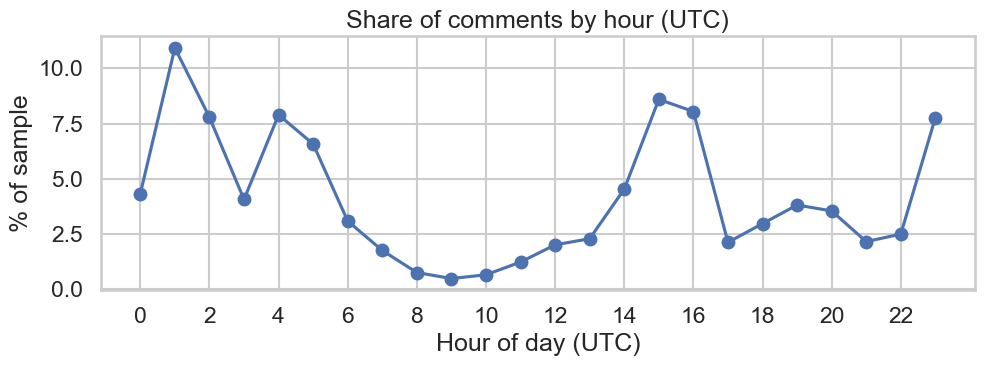

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(hourly_pct.index, hourly_pct.values, marker='o')
ax.set_xticks(range(0, 24, 2))
ax.set_title('Share of comments by hour (UTC)')
ax.set_xlabel('Hour of day (UTC)')
ax.set_ylabel('% of sample')
plt.tight_layout()
plt.show()

## Flair and moderation signals

In [17]:
mod_stats = {
    'moderator_flag_pct': (sample_df['distinguished'] == 'moderator').mean() * 100,
    'admin_flag_pct': (sample_df['distinguished'] == 'admin').mean() * 100,
    'score_hidden_pct': sample_df['score_hidden'].mean() * 100,
    'gilded_comments': int((sample_df['gilded'] > 0).sum()),
}
pd.Series(mod_stats)

moderator_flag_pct     0.7348
admin_flag_pct         0.0003
score_hidden_pct       0.1366
gilded_comments      268.0000
dtype: float64

In [18]:
top_flairs = (sample_df['author_flair_text']
               .dropna()
               .value_counts()
               .head(15)
               .rename_axis('author_flair_text')
               .reset_index(name='comments'))
top_flairs

,author_flair_text,comments
0,♀,989
1,Patriots,931
2,non presser,870
3,Warriors,857
4,CHINHL,834
5,Cowboys,609
6,Eagles,585
7,Spurs,525
8,Bulls,524
9,Raptors,522


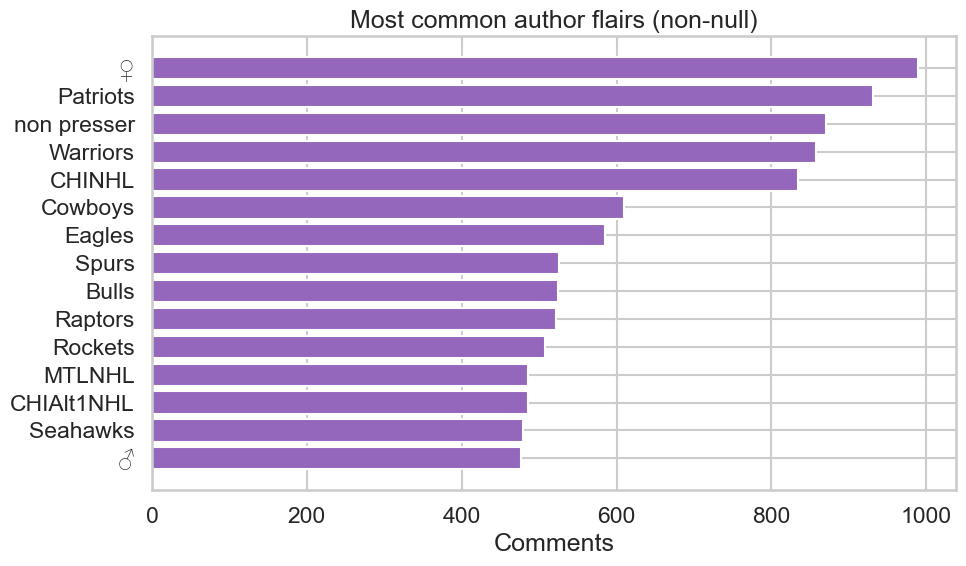

In [19]:
if not top_flairs.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_flairs['author_flair_text'][::-1], top_flairs['comments'][::-1], color='#9467bd')
    ax.set_title('Most common author flairs (non-null)')
    ax.set_xlabel('Comments')
    plt.tight_layout()
    plt.show()
else:
    print('No flair values present in sample.')

## Lexical snapshot

In [20]:
sample_size = 50_000
subset = sample_df['body'].astype(str).sample(sample_size, random_state=RANDOM_SEED)
stopwords = {
    'the','to','and','a','i','it','of','is','in','that','for','you','this','on','be','are','with','have','was','my','but','not',
    'they','as','so','if','just','or','do','at','we','me','your','what','can','about','get','like','from','up','how','out','more','when',
    'would','has','all','no','an','there','one','will','think','had','were','who','because','he','she','their','them','his','her','im','its',
    'dont','did','than','then','been','cant','didnt','into','also','any','some','very','why','should','could','us','really','know','people',
    'make','made','got','http','https','www','com','deleted','amp','time','good','still','even','only','well','want','said','back','much',
    'love','see','now','way','new','anyone','game','year','years','need','makes','going','right','take','look','thing','things','maybe'
}
word_counts = {}
for text in subset:
    text = text.lower()
    text = ''.join(ch if ch.isalpha() or ch.isspace() else ' ' for ch in text)
    for token in text.split():
        if len(token) > 2 and token not in stopwords:
            word_counts[token] = word_counts.get(token, 0) + 1

word_freq = (pd.Series(word_counts)
             .sort_values(ascending=False)
             .head(25)
             .rename_axis('token')
             .reset_index(name='frequency'))
word_freq

,token,frequency
0,don,4881
1,other,2347
2,too,2250
3,him,2115
4,here,2048
...,...,...
20,after,1557
21,better,1556
22,those,1544
23,never,1532


## Insights

- Score dynamics: ~44% of comments land at score 1, and ~7% exceed 10. Heavy-tailed upvotes mean the top 1% of comments reach ≥66 score, while 4.4% are net-negative.
- Comment quality: Median comment is 81 characters/14 words, but the 95th percentile stretches past 600 characters. Links appear in ~5.9% of rows; `[deleted]` text accounts for ~5.7%.
- Engagement signals: `downs` are zeroed in this dump and `ups` mirrors `score`, so modelling should rely on `score` or derive `ups` externally. Moderation markers are rare (0.73% `distinguished == "moderator"`; gilded comments ≈0.03%).
- Community distribution: AskReddit dominates volume (≈63k of 800k sample) followed by large entertainment/sports subreddits. Niches like r/dataisbeautiful show high mean scores despite lower comment counts.
- Temporal cadence: Activity in this snapshot concentrates between January–May 2015 with peaks around 01:00–05:00 UTC and another late-afternoon (15:00–16:00 UTC) rise.
- Flair signals: Sports-team flairs (Patriots, Warriors, Cowboys) and gender markers account for much of the non-null flair data, suggesting cultural/region features for feature engineering.
- Language cues: Frequent tokens after stopword removal focus on comparative/qualifying words (“other”, “being”, “which”), emphasising conversational and explanatory tone.

## Recommendations
1. Drop or ignore fully-null operational columns (`approved_by`, `replies`, `likes`, etc.) to reduce memory footprint.
2. Treat `body` values that are `[deleted]`/`[removed]` as their own category; they can signal moderation or churn behaviour.
3. Engineer features from `score` percentiles (log-scale, capped) instead of raw scores to reduce skew, and be mindful that `ups` duplicates `score` while `downs` is zero.
4. Derive temporal features (UTC hour, weekday, recency) — the sample shows clear overnight/afternoon peaks that could enhance engagement models.
5. Use subreddit- or flair-level aggregations to capture community effects; sports and general-interest subs behave differently in both volume and score variance.
6. When running NLP, remove HTML entities (e.g., `amp`) and URLs; consider lemmatisation to mitigate remaining filler tokens.